In [28]:
!pip install statsmodels


In [12]:
import pandas as pd

df = pd.read_csv('test.csv', parse_dates=['Date'])
df.head()

,Date,Store,Dept,Weekly_Sales
0,2015-01-05,1,1,22483.570765
1,2015-01-12,1,1,19308.678494
2,2015-01-19,1,1,23238.442691
3,2015-01-26,1,1,27615.149282
4,2015-02-02,1,1,18829.233126


In [13]:
print("shape of the dataset",df.shape)
df.info()

shape of the dataset (3915, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 0 to 3914
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3915 non-null   datetime64[ns]
 1   Store         3915 non-null   int64         
 2   Dept          3915 non-null   int64         
 3   Weekly_Sales  3915 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 122.5 KB


In [14]:
print("Unique Stores: ",df['Store'].nunique())
print("Unique Departments: ",df['Dept'].nunique())
print("Date Range ",df['Date'].min(),"to",df['Date'].max())

df.isnull().sum()

Unique Stores:  5
Unique Departments:  3
Date Range  2015-01-05 00:00:00 to 2019-12-30 00:00:00


,0
Date,0
Store,0
Dept,0
Weekly_Sales,0


SALES OVER 5 YEARS

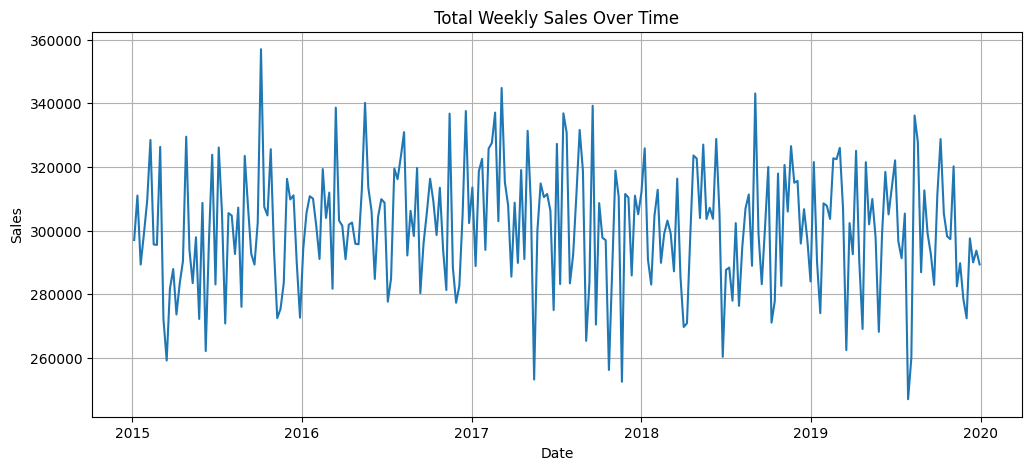

In [15]:
import matplotlib.pyplot as plt


sales_by_date = df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(12, 5))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


FEATURE ENGINEARING

In [16]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek

df.head()


,Date,Store,Dept,Weekly_Sales,Year,Month,Week,DayOfWeek
0,2015-01-05,1,1,22483.570765,2015,1,2,0
1,2015-01-12,1,1,19308.678494,2015,1,3,0
2,2015-01-19,1,1,23238.442691,2015,1,4,0
3,2015-01-26,1,1,27615.149282,2015,1,5,0
4,2015-02-02,1,1,18829.233126,2015,2,6,0


In [20]:

df.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)

df['Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)

df[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Lag_1']].head(10)

# Rolling average (last 4 weeks)
df['Rolling_Mean_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1).rolling(4).mean()
df[['Store', 'Dept', 'Date', 'Weekly_Sales', 'Lag_1', 'Rolling_Mean_4']].head(10)



,Store,Dept,Date,Weekly_Sales,Lag_1,Rolling_Mean_4
0,1,1,2015-02-02,18829.233126,NaN,NaN
1,1,1,2015-02-09,18829.315215,18829.233126,NaN
2,1,1,2015-02-16,27896.064078,18829.315215,NaN
3,1,1,2015-02-23,23837.173646,27896.064078,NaN
4,1,1,2015-03-02,17652.628070,23837.173646,22347.946516
5,1,1,2015-03-09,22712.800218,17652.628070,22053.795252
6,1,1,2015-03-16,17682.911536,22712.800218,23024.666503
7,1,1,2015-03-23,17671.351232,17682.911536,20471.378367
8,1,1,2015-03-30,21209.811358,17671.351232,18929.922764
9,1,1,2015-04-06,10433.598777,21209.811358,19819.218586


In [21]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [22]:
cutoff_date = '2019-01-01'

train_df = df[df['Date'] < cutoff_date]
test_df = df[df['Date'] >= cutoff_date]

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)


Train size: (3015, 10)
Test size: (780, 10)


In [23]:
features = ['Lag_1', 'Rolling_Mean_4', 'Month', 'Week', 'DayOfWeek']
target = 'Weekly_Sales'

MODEL TRAINING

In [24]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_df[features], train_df[target])


LinearRegression()

PREDICTION

In [25]:
test_df['Predicted_Sales'] = model.predict(test_df[features])

/tmp/ipython-input-25-4243311223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Sales'] = model.predict(test_df[features])


ROOT MEAN SQUARE

In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_df['Weekly_Sales'], test_df['Predicted_Sales']))
print("RMSE:", rmse)


RMSE: 4956.13794778421


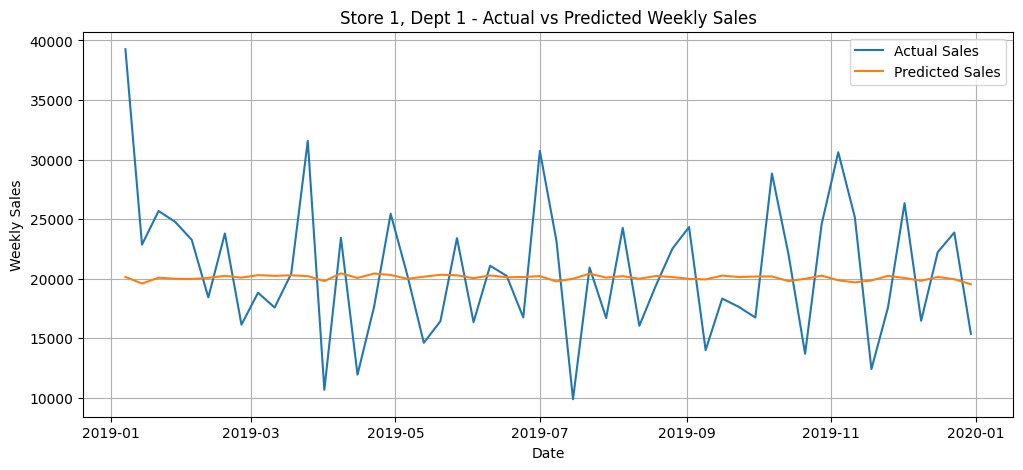

In [27]:
import matplotlib.pyplot as plt


sample = test_df[(test_df['Store'] == 1) & (test_df['Dept'] == 1)]


plt.figure(figsize=(12, 5))
plt.plot(sample['Date'], sample['Weekly_Sales'], label='Actual Sales')
plt.plot(sample['Date'], sample['Predicted_Sales'], label='Predicted Sales')
plt.title('Store 1, Dept 1 - Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


PREDICT FUTURE

In [29]:
def forecast_future_sales(model, df_history, start_date, weeks):
    import pandas as pd
    import numpy as np

    future_dates = pd.date_range(start=start_date, periods=weeks, freq='W-MON')

    store_dept_keys = df_history[['Store', 'Dept']].drop_duplicates()

    # Create empty list
    all_predictions = []

    for _, row in store_dept_keys.iterrows():
        store = row['Store']
        dept = row['Dept']

        history = df_history[(df_history['Store'] == store) & (df_history['Dept'] == dept)].copy()
        history = history.sort_values('Date')

        recent_sales = history[['Date', 'Weekly_Sales']].tail(4).copy()

        predictions = []
        for date in future_dates:
            lag_1 = recent_sales['Weekly_Sales'].iloc[-1]
            rolling_mean_4 = recent_sales['Weekly_Sales'].rolling(4).mean().iloc[-1]

            month = date.month
            week = date.isocalendar()[1]
            dayofweek = date.weekday()

            X_input = pd.DataFrame([{
                'Lag_1': lag_1,
                'Rolling_Mean_4': rolling_mean_4,
                'Month': month,
                'Week': week,
                'DayOfWeek': dayofweek
            }])

            predicted_sales = model.predict(X_input)[0]

            predictions.append({
                'Store': store,
                'Dept': dept,
                'Date': date,
                'Predicted_Sales': predicted_sales
            })
            recent_sales = pd.concat([
                recent_sales,
                pd.DataFrame({'Date': [date], 'Weekly_Sales': [predicted_sales]})
            ]).tail(4)

        all_predictions.extend(predictions)

    return pd.DataFrame(all_predictions)


In [32]:
forecast_df = forecast_future_sales(model, df, start_date='2022-01-03', weeks=52)

forecast_df.head()


,Store,Dept,Date,Predicted_Sales
0,1,1,2021-01-04,20364.664618
1,1,1,2021-01-11,20212.551856
2,1,1,2021-01-18,20230.018377
3,1,1,2021-01-25,20247.425217
4,1,1,2021-02-01,20188.962717


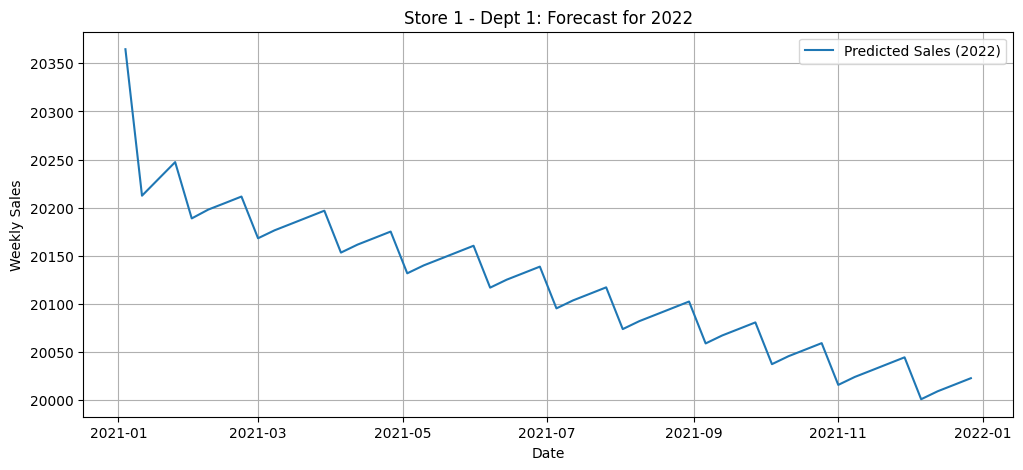

In [33]:
sample = forecast_df[(forecast_df['Store'] == 1) & (forecast_df['Dept'] == 1)]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(sample['Date'], sample['Predicted_Sales'], label='Predicted Sales (2022)')
plt.title('Store 1 - Dept 1: Forecast for 2022')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.legend()
plt.show()
